In [1]:
import numpy as np
import pandas as pd
import struct
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('darkgrid')
import sys
import os
import seaborn
from  matplotlib import pyplot

In [2]:
import io

# functions for reading files
def read_data(start, end, paths, file_name, label_name):
    data = []
    for path in paths:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{file_name}_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(pd.read_csv(data_path))
                data[-1]['conf'] = i
                data[-1][label_name] = path[1]
    
    return pd.concat(data)

In [3]:
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    fg.savefig(output_path, dpi=400, facecolor='white')

In [4]:
# functions for wrappings processing

# save image
def save_image_time_wrappings(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    fg.savefig(output_path, dpi=400)

# make plots
def make_plot_time_wrappings(data, hue_name):
    wrapping_number = data['winding_number'].iloc[0]
    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.61)
    fg.fig.suptitle(f'winding_number = {wrapping_number}')
    fg.map(plt.errorbar, hue_name, 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    # save_image_time_wrappings('../../images/common', f'time-wrappings_wrapping_number={wrapping_number}', fg)

def data_process_wrappings(data, hue_name):
    return data.groupby(['winding_number', hue_name, 'conf'])['cluster_number']\
        .agg([('cluster_number', np.mean)]).reset_index()\
        .groupby(['winding_number', hue_name])['cluster_number']\
        .agg([('cluster_number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

# fill with zeros missing values
def fill_windings(data):
    return data.set_index(['conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack()

def wrappings_time_dependence(start, end, paths, hue_name):
    data = read_data(start, end, paths, 'windings', hue_name)
    # data = read_data(start, end, paths, 'wrappings', read_wrappings)

    data = data[data['direction'] == 'time']
    data = data.drop(columns=['direction'])
    data = data.set_index([hue_name, 'conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack()
    # data = data.groupby(['time size'])[['color', 'cluster_number', 'winding_number', 'conf']].apply(fill_windings).reset_index()

    data = data_process_wrappings(data, hue_name)

    data.groupby(['winding_number']).apply(make_plot_time_wrappings, hue_name)
    
    # data.to_csv('../../data/wrappings_common', sep = ' ', index=False)
    
def wrappings_number_dependence(start, end, paths):
    data = read_data(start, end, paths, 'windings', read_wrappings)

    data = data[data['direction'] == 'time']
    data = data.drop(columns=['direction'])
    data = data.set_index(['time size', 'conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack().reset_index()

    data = data_process_wrappings(data)
    
    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    plt.yscale('log')
    fg.map(plt.errorbar, 'winding_number', 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    # save_image_time_wrappings('../../images/common', f'number-wrappings', fg)
    
    # data.to_csv('../../data/wrappings_common', sep = ' ', index=False)

# fit functions
def exponent(x, a, mu):
    return a * np.exp(-mu * x) * np.power(x, -5/2)

def exponent1(x, a, mu, b):
    return a * np.exp(-mu * x) * np.power(x, -b)

def inverse_polinomial(x, a):
    return a * np.power(x, -5/2)

def inverse_polinomial1(x, a, b):
    return a * np.power(x, -b)

def fit_data(data, func):
    popt, pcov = curve_fit(func, data['winding_number'].to_numpy(), data['cluster_number'].to_numpy())
    return pd.Series({'params': popt})

def fit_data_polinomial(data):
    popt, pcov = curve_fit(inverse_polinomial, data['winding_number'].to_numpy(), data['cluster_number'].to_numpy())
    return pd.Series({'a': popt[0]})

def plot_fit_func_exponent(data, min, max):
    x = np.arange(min, max, 0.001)
    y = exponent(x, data['params'].iloc[0][0], data['params'].iloc[0][1])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_fit_func_exponent1(data, min, max):
    x = np.arange(min, max, 0.001)
    y = exponent1(x, data['params'].iloc[0][0], data['params'].iloc[0][1], data['params'].iloc[0][2])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_fit_func_polinomial(data, min, max):
    x = np.arange(min, max, 0.001)
    y = inverse_polinomial(x, data['params'].iloc[0][0])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_fit_func_polinomial1(data, min, max):
    x = np.arange(min, max, 0.001)
    y = inverse_polinomial1(x, data['params'].iloc[0][0], data['params'].iloc[0][1])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_test(data):
    plt.plot(data['winding_number'], data['cluster_number'])

def fit_wrappings(start, end, paths, ranges, func, plotting_func, name):
    data = read_data(start, end, paths, 'windings', read_wrappings)

    data = data[data['direction'] == 'time']
    data = data.drop(columns=['direction'])
    data = data.set_index(['time size', 'conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack()
    
    data = data_process_wrappings(data)

    # print(data)
    # data.to_csv('../../data/wrappings_common', sep = ',', index=False)

    for d in ranges:
        data = data[(data['winding_number'] <= ranges[d][1]) | np.logical_not((data['time size'] == d))]
        data = data[(data['winding_number'] >= ranges[d][0]) | np.logical_not((data['time size'] == d))]

    df = data.groupby(['time size']).apply(fit_data, func).reset_index()
    # print(df)

    # df1 = df.groupby(['time size']).apply(plot_fit_func_polinomial, data['winding_number'].min(), data['winding_number'].max())
    df1 = df.groupby(['time size']).apply(plotting_func, data['winding_number'].min(), data['winding_number'].max())

    df1.index = df1.index.get_level_values('time size')
    df1 = df1.reset_index()

    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    plt.yscale('log')
    fg.map(plt.errorbar, 'winding_number', 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    df1.groupby(['time size']).apply(plot_test)

    # save_image_time_wrappings('../../images/common/fit', f'{name}', fg)
    # plt.plot(df1['winding_number'], df1['monopole number'])
    return df

In [ ]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/windings', 'tol=1e-05'),
        ('../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/tol=1e-07/windings', 'tol=1e-07'),
        ('../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/tol=1e-13/windings', 'tol=1e-13')]
wrappings_time_dependence(501, 1200, paths, 'tol')

In [ ]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/windings', 'tol=1e-05'),
        ('../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/tol=1e-07/windings', 'tol=1e-07'),
        ('../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/tol=1e-13/windings', 'tol=1e-13')]
wrappings_time_dependence(501, 1200, paths, 'tol')

In [ ]:
paths_new = [('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

paths_old = [('../data/monopoles_su3/nt6/steps_330/copies=1', 6), ('../data/monopoles_su3/nt8/steps_330/copies=1', 8), \
        ('../data/monopoles_su3/nt10/steps_330/copies=1', 10), ('../data/monopoles_su3/nt12/steps_330/copies=1', 12), \
        ('../data/monopoles_su3/nt14/steps_330/copies=1', 14)]

image_path = '../images/monopoles_su3/QCD/140MeV/windings_old_and_new'

wrappings_number_dependence_old_and_new(501, 1200, paths_new, paths_old, image_path)

In [ ]:
# paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
#         ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
#         ('../../data/nt14/steps_330/copies=1', 14)]

ranges = {4: (2, 7), 6: (2, 7), 8: (2, 13), 10: (4, 20), 12: (3, 20), 14: (3, 20)}

df = []

paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent, plot_fit_func_exponent, 'fixed_4-8'))

paths = [('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent, plot_fit_func_exponent, 'fixed_10-14'))

df = pd.concat(df)
# print(df)
params = df['params'].to_numpy()
arr_mu = []
for i in range(len(params)):
    arr_mu.append(params[i][1])
# print('arr_mu ', arr_mu)
df['mu'] = arr_mu
# print(df)
# print(df['params'])
# print(data)

# df['aT'] =  1 / df['time size']
df['aT'] =  df['time size']

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'mu', marker="o", fmt='', linestyle = '').add_legend()

# save_image_time_wrappings('../../images/common/fit', f'mu_fixed', fg)

In [ ]:
ranges = {4: (2, 6), 6: (2, 7), 8: (2, 6), 10: (4, 20), 12: (3, 20), 14: (3, 20)}

df = []

paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), \
        ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8)]

df.append(fit_wrappings(501, 1200, paths, ranges, inverse_polinomial, plot_fit_func_polinomial, 'fixed_4-8'))

paths = [('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

df.append(fit_wrappings(501, 1200, paths, ranges, inverse_polinomial, plot_fit_func_polinomial, 'fixed_10-14'))

df = pd.concat(df)
# print(df)
params = df['params'].to_numpy()
arr_mu = []
for i in range(len(params)):
    arr_mu.append(params[i][0])
# print('arr_mu ', arr_mu)
df['mu'] = arr_mu
# print(df)
# print(df['params'])
# print(data)

df['aT'] =  1 / df['time size']

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'mu', marker="o", fmt='', linestyle = '').add_legend()

In [ ]:
ranges = {4: (2, 7), 6: (2, 7), 8: (2, 13), 10: (4, 20), 12: (3, 20), 14: (3, 20)}

df = []

paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent1, plot_fit_func_exponent1, 'unfixed_6-8'))

paths = [('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent1, plot_fit_func_exponent1, 'unfixed_10-14'))

df = pd.concat(df)
# print(df)
params = df['params'].to_numpy()
arr_mu = []
arr_b = []
for i in range(len(params)):
    arr_mu.append(params[i][1])
    arr_b.append(params[i][2])
df['mu'] = arr_mu
df['b'] = arr_b

df['aT'] =  1 / df['time size']

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'mu', marker="o", fmt='', linestyle = '').add_legend()

save_image_time_wrappings('../../images/common/fit', f'mu_unfixed', fg)

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'b', marker="o", fmt='', linestyle = '').add_legend()

save_image_time_wrappings('../../images/common/fit', f'b_unfixed', fg)

In [ ]:
df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                   columns=['a', 'b', 'c'])

print(df2)

def test_func(data):
    return pd.Series({'e': 1, 'd': 3})

df2 = df2.groupby(['a'])['b'].apply(test_func).unstack().reset_index()
print(df2)

In [ ]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

wrappings_time_dependence(501, 1200, paths)

In [ ]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

wrappings_time_dependence(501, 1200, paths)

In [ ]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

wrappings_number_dependence(501, 1200, paths)

In [ ]:
paths = [('../data/monopoles_su3/nt6/steps_330/copies=1', 6), ('../data/monopoles_su3/nt8/steps_330/copies=1', 8), \
        ('../data/monopoles_su3/nt10/steps_330/copies=1', 10), ('../data/monopoles_su3/nt12/steps_330/copies=1', 12), \
        ('../data/monopoles_su3/nt14/steps_330/copies=1', 14)]

wrappings_time_dependence(501, 1200, paths)

In [ ]:
paths = [('../../data/nt4/steps_2000/copies=1', 4), ('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
        ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

wrappings_number_dependence(501, 1200, paths)

In [5]:
# functions for density of wrapped and unwrapped clusters

def data_process_density(data, label_name):
    return data.groupby(['cluster size', label_name, 'conf'])['number']\
        .agg([('number', np.sum)]).reset_index()\
        .groupby(['cluster size', label_name])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def density_lower(start, end, paths, ranges, wrapp):
    
    data = read_data(start, end, paths, wrapp, read_density_lower)
    
    data['number'] = data['number'] / data['time size']
    
    data = data_process_density(data)
    
    for r in ranges:
                
        df = data[data['cluster size'] <= r[1]]
        df = df[df['cluster size'] >= r[0]]
    
    
#     data['number']  = data['number'] * data['cluster size'] * data['cluster size']
    
#     df['number'] = df['number'] * df['cluster size']
    
        fg = seaborn.FacetGrid(data=df, hue = 'time size', height=5, aspect=1.61)
        fg.fig.suptitle(f'cluster density')
        plt.yscale('log')
        fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
        image_path = f'../../images/common'
        try:
            os.makedirs(image_path)
        except:
            pass
    
        image_path = f'{image_path}/monopole_density_{wrapp}_{r[0]}_{r[1]}'
        fg.savefig(image_path, dpi=400)
        
    data.to_csv(f'../../data/{wrapp}_common', sep = ' ', index=False)
    
def density_lower_time_dependence(start, end, paths, cluster_sizes, wrapp):
    
    data = read_data(start, end, paths, wrapp, read_density_lower)
    
    data['number'] = data['number'] / data['time size']
    
    data = data_process_density(data)
    
    for size in cluster_sizes:
                
        df = data[data['cluster size'] == size]
    
#     data['number']  = data['number'] * data['cluster size'] * data['cluster size']
    
#     df['number'] = df['number'] * df['cluster size']
    
        fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
#         fg.fig.suptitle(f'cluster size = {size}')
#         plt.yscale('log')
        fg.map(plt.errorbar, 'time size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
        image_path = f'../../images/common'
        try:
            os.makedirs(image_path)
        except:
            pass
    
        image_path = f'{image_path}/monopole_density_time_{wrapp}_size={size}'
        fg.savefig(image_path, dpi=400)

def fill_unwrapped_upper(data):
    return data.set_index(['conf','color', 'length']).unstack('length', fill_value=0).stack()

def make_bins(data):
    print(data)
    bin_size = (data.name.left + data.name.right) / 2
    return data.sum()/bin_size

def data_process_upper(data, bin_num):
    return data.groupby([pd.cut(data['cluster size'], bin_num)])['number']\
        .apply(make_bins).reset_index()\
        .groupby(['cluster size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))])

def density_upper(start, end, paths, bin_num, wrapp):
    data = read_data(start, end, paths, wrapp, read_density_upper)

    data = data.groupby(['time size'])[['color', 'cluster size', 'number', 'conf']].apply(fill_unwrapped_upper).reset_index()

    # print(data)

    data = data.groupby(['cluster size', 'time size', 'conf'])['number']\
        .agg([('number', np.mean)]).reset_index()\
        .groupby(['time size'])\
        .apply(data_process_upper, bin_num).reset_index()

    data['cluster size'] = data['cluster size'].apply(lambda x: (x.right + x.left) / 2)

    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    plt.yscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    # print(data)

def plot_density_single(data, label_name, image_path, image_name):
    size = data['length'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = label_name, height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    fg.map(plt.errorbar, 'length', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    save_image(image_path, f'{image_name}_size={size}', fg)

def density_single(start, end, paths, file_name, label_name, size_max, image_path, image_name):
    data = read_data(start, end, paths, file_name, label_name)
    data = data.groupby([label_name])[['color', 'length', 'number', 'conf']].apply(fill_unwrapped_upper).reset_index()
    data = data_process_density(data, label_name)
    data = data[data['length'] <= size_max]
    data.groupby(['length']).apply(plot_density_single, label_name, image_path, image_name)


def maximal_cluster(start, end, paths):
    data = []
    data.append(read_data(start, end, paths, 'unwrapped', read_density_upper))
    data.append(read_data(start, end, paths, 'wrapped', read_density_upper))

    data = pd.concat(data)
    
def statistics_unwrapped_upper(start, end, paths, copies, bin_num, max_length):
    data = read_data_history(start, end, paths, copies, 'unwrapped', read_unwrapped_upper)
    
    data = data[data['cluster size'] <= max_length]

    data = data.groupby(['copy', 'steps'])[['color', 'cluster size', 'number' , 'num']].apply(fill_unwrapped_upper).reset_index()

    data = data.groupby(['cluster size', 'steps', 'copy', 'num'])['number']\
        .agg([('number', np.sum)]).reset_index()
    data = data.groupby([pd.cut(data['cluster size'], bin_num), 'steps', 'copy', 'num'])['number']\
        .apply(make_bins).reset_index()\
    .groupby(['cluster size', 'steps', 'copy'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()
    
    data['cluster size'] = data['cluster size'].apply(lambda x: (x.right + x.left) / 2)
    
    return data
    
def make_plot_time_density(data, hue_name):
    wrapping_number = data['length'].iloc[0]
    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.61)
    fg.fig.suptitle(f'winding_number = {wrapping_number}')
    fg.map(plt.errorbar, hue_name, 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

def data_process_density(data, hue_name):
    return data.groupby(['length', hue_name, 'conf'])['number']\
        .agg([('number', np.mean)]).reset_index()\
        .groupby(['length', hue_name])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

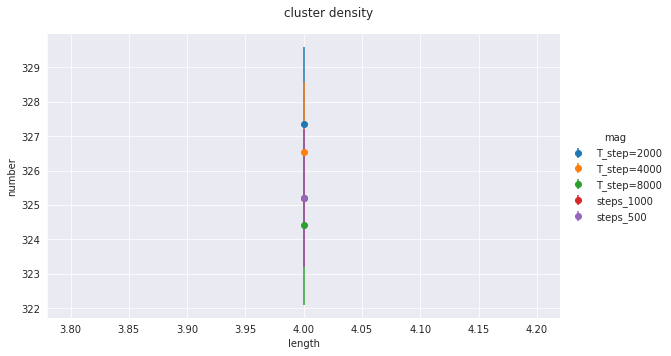

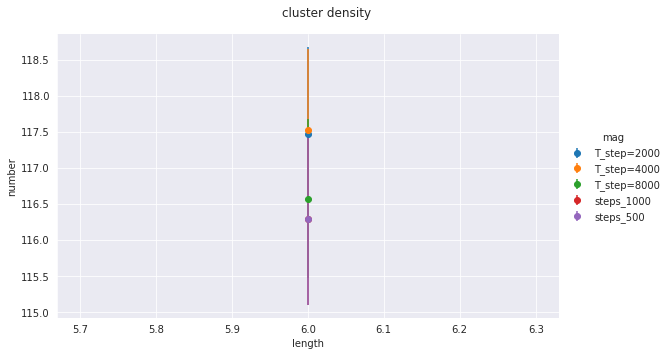

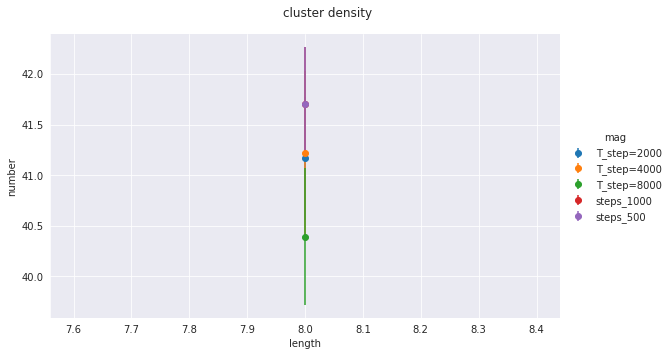

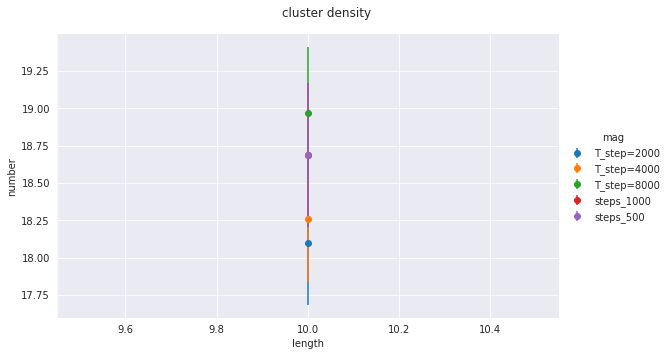

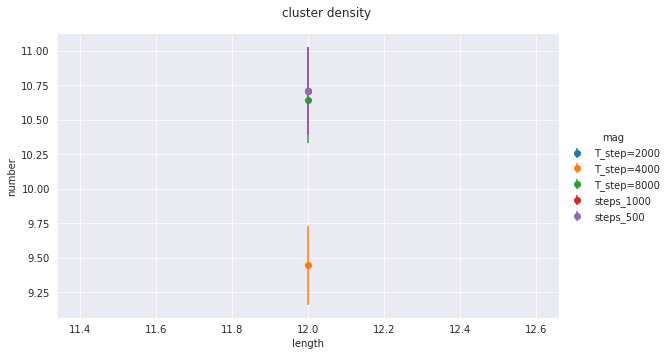

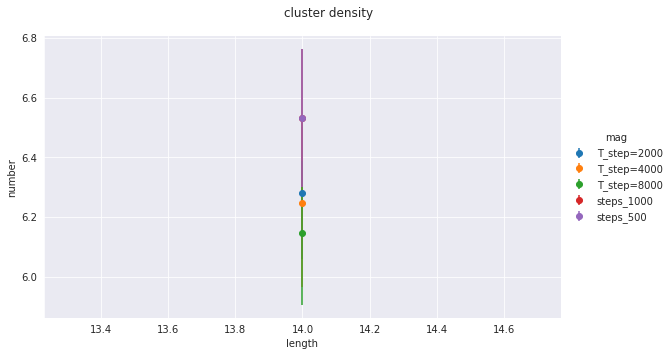

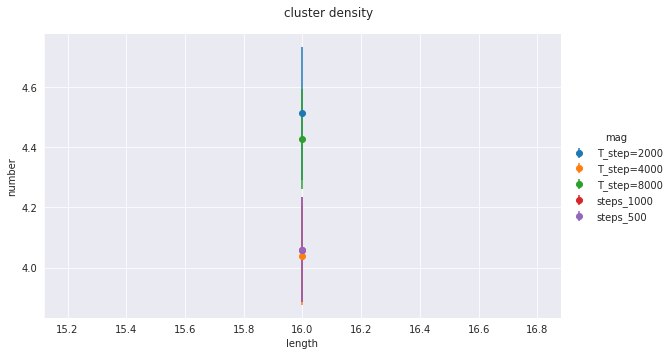

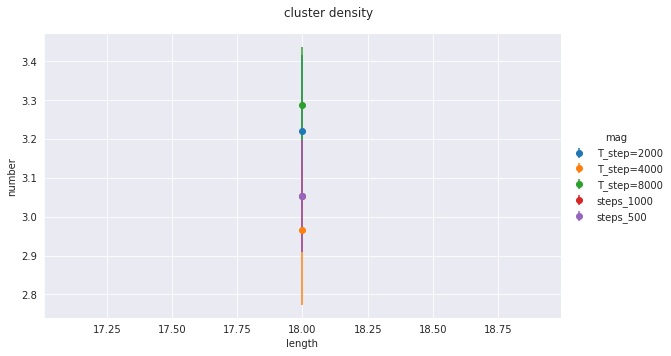

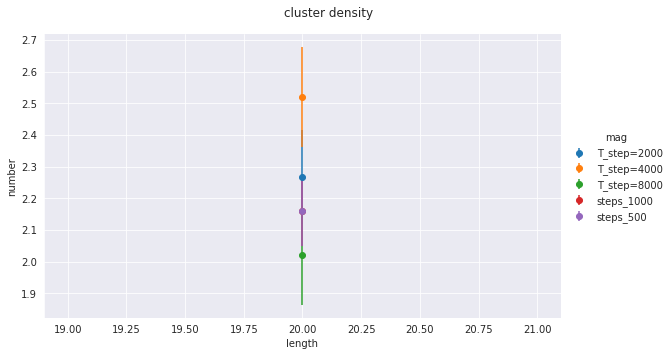

In [30]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths = [(f'{path}/steps_500/copies=3/clusters_unwrapped', 'steps_500'), 
        (f'{path}/steps_500/copies=3/clusters_unwrapped', 'steps_1000'),
        (f'{path}/steps_2000/copies=3/clusters_unwrapped', 'T_step=2000'),
        (f'{path}/steps_4000/copies=3/clusters_unwrapped', 'T_step=4000'),
        (f'{path}/steps_8000/copies=3/clusters_unwrapped', 'T_step=8000')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'density_single'

density_single(1, 50, paths, 'clusters_unwrapped', 'mag', 20, image_path, image_name)

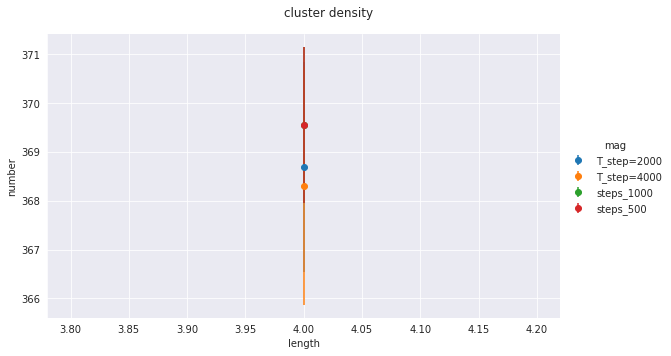

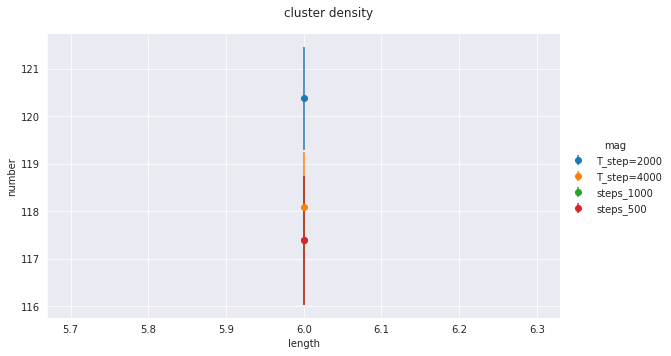

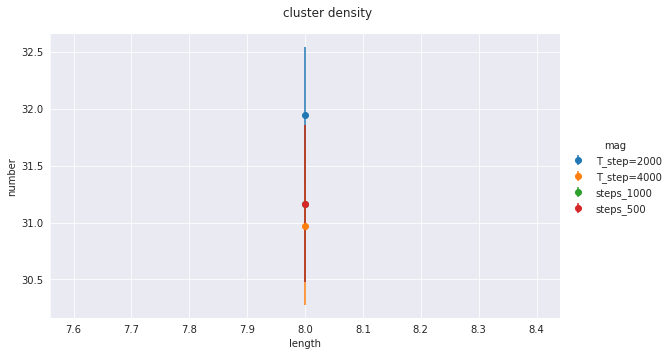

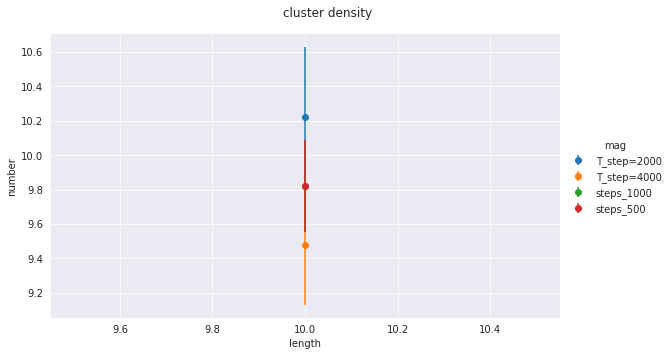

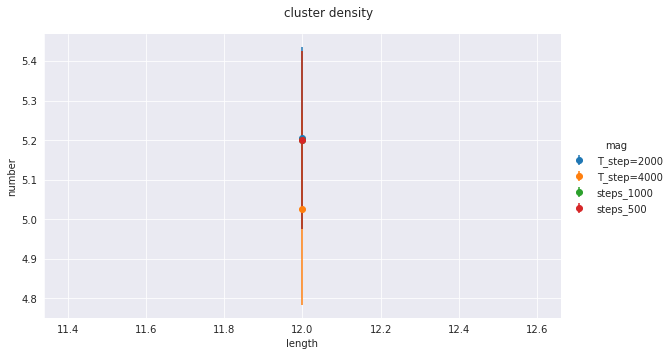

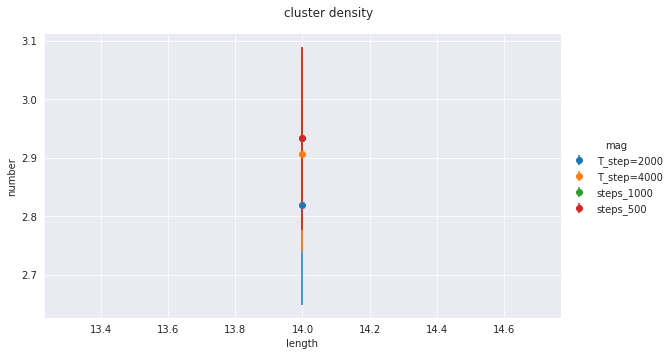

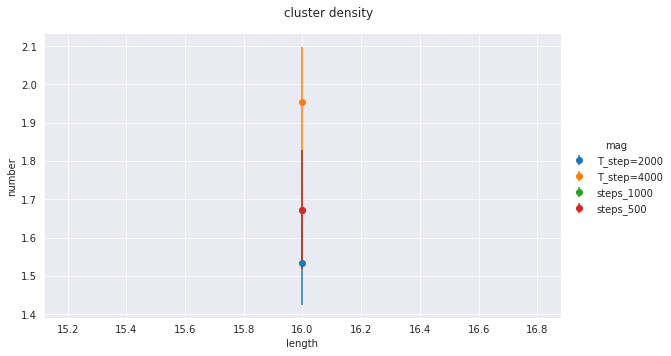

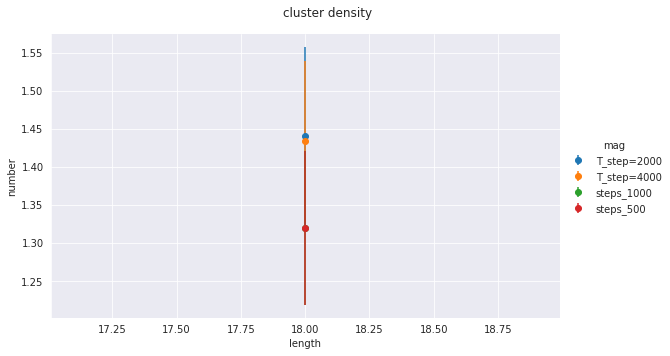

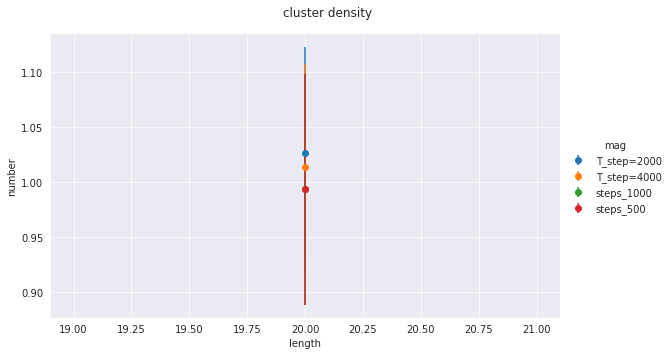

In [20]:
path = '../data/monopoles_su3/gluodynamics/36^4/beta6.3'
paths = [(f'{path}/steps_500/copies=3/clusters_unwrapped', 'steps_500'), 
        (f'{path}/steps_500/copies=3/clusters_unwrapped', 'steps_1000'),
        (f'{path}/steps_2000/copies=3/clusters_unwrapped', 'T_step=2000'),
        (f'{path}/steps_4000/copies=3/clusters_unwrapped', 'T_step=4000')]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.0'
image_name = 'density_single'

density_single(1, 50, paths, 'clusters_unwrapped', 'mag', 20, image_path, image_name)

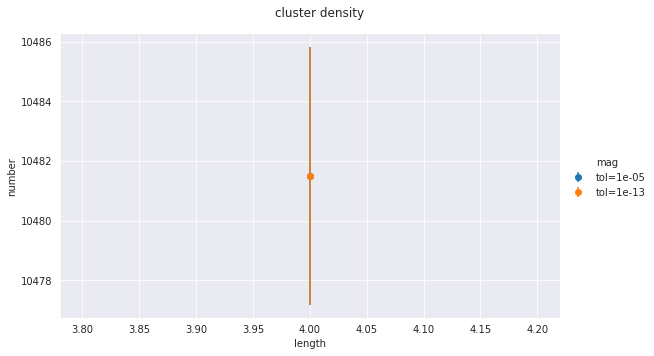

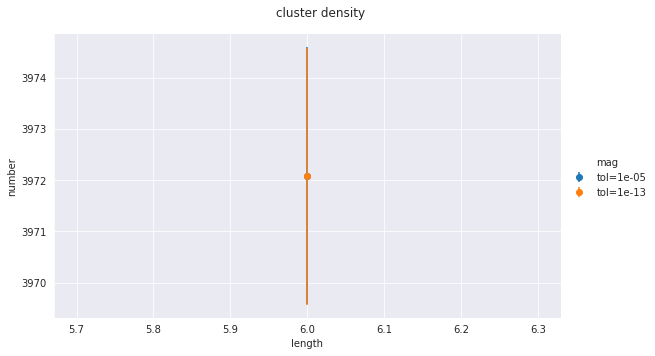

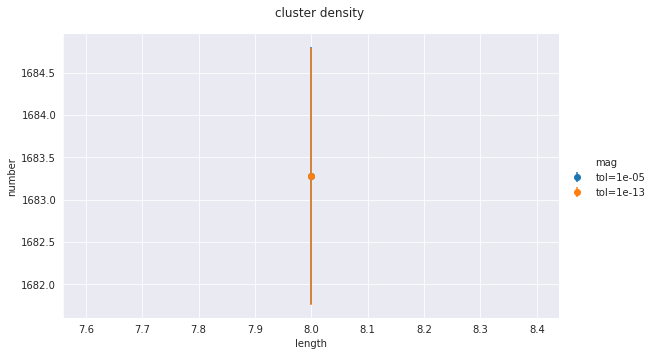

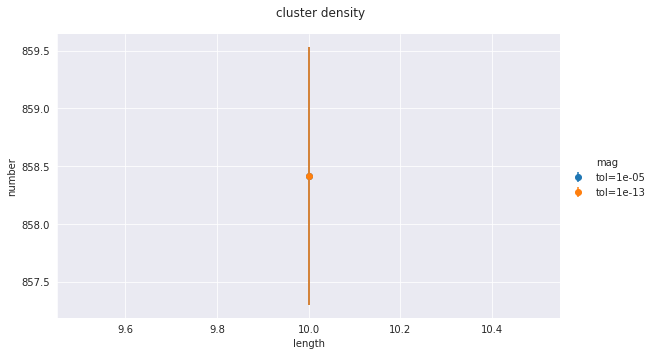

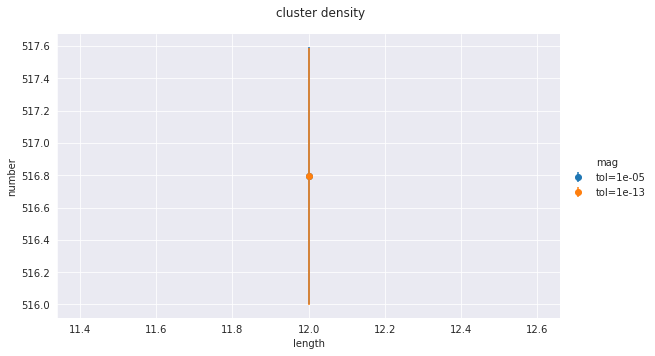

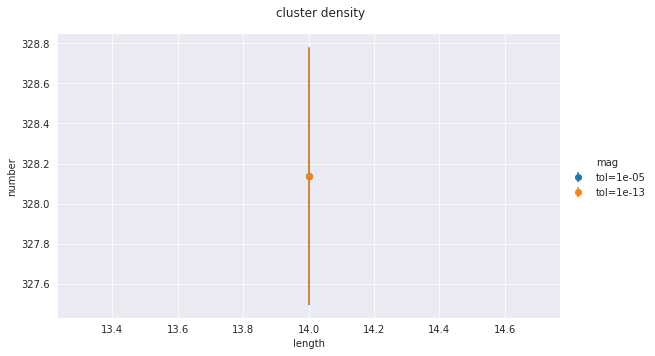

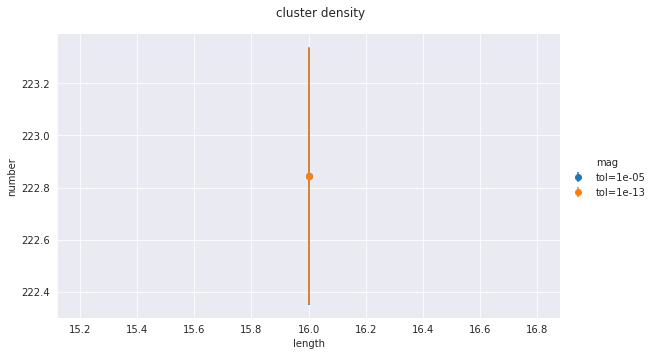

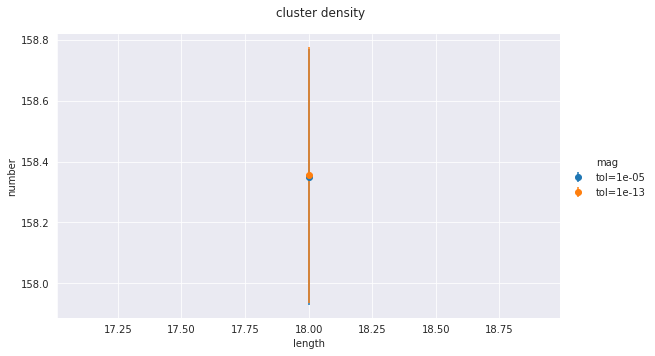

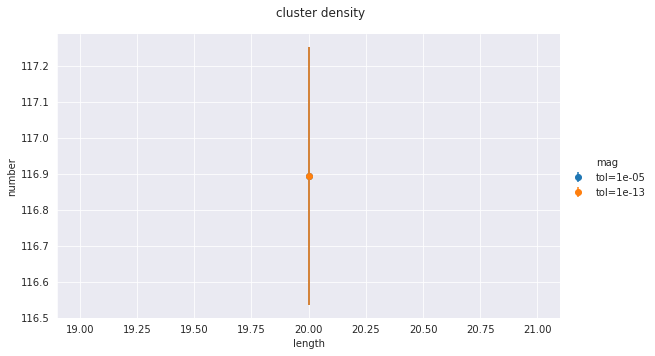

In [36]:
path = '../data/monopoles_su3/QCD/140MeV/nt14'
paths = [(f'{path}/steps_2000/copies=1/clusters_unwrapped', 'tol=1e-05'), 
        (f'{path}/steps_2000/copies=1/tol=1e-13/clusters_unwrapped', 'tol=1e-13')]
image_path = '../images/monopoles_su3/QCD/140MeV/nt14'
image_name = 'density_single'

density_single(501, 1200, paths, 'clusters_unwrapped', 'mag', 20, image_path, image_name)

In [ ]:
paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
        ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

ranges = [(0, 25), (25, 75), (75, 202), (0, 202)]
# ranges = [(0, 202)]

density_lower(501, 1200, paths, ranges, 'wrapped')

In [ ]:
# 6  128.667     1.991 54399.7    50.33 
#   8  438.468     12.09  81534.2   104
#   10 2563.08     99.02  112293     96.24 
#   12 19898.5     582.6   142390     134.8
#   14 38158.7     913.7  171480       117

x = np.array([[6, 8, 10, 12, 14], [128.667, 438.468, 2563.08, 19898.5, 38158.7], [1.991, 12.09, 99.02, 582.6, 913.7],
        [54399.7, 81534.2, 112293, 142390, 171480], [50.33, 104, 96.24, 134.8, 117]])

data = pd.DataFrame(np.transpose(x),
        columns=['nt', 'N_max', 'N_max err', 'N_tot', 'N_tot err'])

data['ratio'] = data['N_max'] / data['N_tot']
data['ratio err'] = data.apply(lambda x: math.sqrt(x['N_max err'] ** 2 / x['N_tot'] ** 2 + x['N_tot err'] ** 2 * x['N_max'] ** 2 / x['N_tot'] ** 4), axis=1)

print(data)



fg = seaborn.FacetGrid(data=data, height=5, aspect=1.61)
# plt.yscale('log')
fg.map(plt.errorbar, 'nt', 'ratio', 'ratio err', marker="o", fmt='', linestyle = '').add_legend()
fg.ax.set_ylabel(r"$N_{max}/N_{tot}$", fontsize=10)
fg.ax.set_xlabel(r"Nt", fontsize=10)

fg.savefig('../images/monopoles_su3/QCD/140MeV/max_cluster/ratio', dpi=400)

In [7]:
def find_percolating(data, threshold):
    conf = data['conf'].iloc[0]
    if data.shape[0] >= 2:
        conf = data['conf'].iloc[0]
        data = data.sort_values(by=['length'])
        if (data['length'].iloc[-1] > threshold) or (data['length'].iloc[-2] > threshold):
            return data.iloc[-2:]
        else: 
            return pd.DataFrame([[0, 0, 'time', conf]], columns=['length', 'number', 'direction', 'conf'])
    else:
        return pd.DataFrame([[0, 0, 'time', conf]], columns=['length', 'number', 'direction', 'conf'])

# def get_large_wrapped(data, threshold):
#     print(data)
#     data_time = data[data['direction'] == 'time']
#     data_space = data[data['direction'] == 'space']
#     data_both = data[data['direction'] == 'both']
#     if not data_time.empty:
#         data_time = find_percolating(data_time, threshold)
#     if not data_space.empty:
#         data_space = find_percolating(data_space, threshold)
#     if not  data_both.empty:
#         data_both = find_percolating(data_both, threshold)
#     return pd.concat([data_time, data_space, data_both])
def get_large_wrapped(data, threshold):
    data = find_percolating(data, threshold)
    return data


def clusters_divide(data_unwrapped, data_wrapped, size_threshold):
    data_large_unwrapped = data_unwrapped[data_unwrapped['length'] > size_threshold]
    # print(data_wrapped)
    data_large_wrapped = data_wrapped.groupby(['conf']).apply(get_large_wrapped, size_threshold).reset_index(drop=True)
    # print(data_large_wrapped)
    # data_large_wrapped = data_large_wrapped.drop('direction', axis = 1)

    data_large = pd.concat([data_large_unwrapped, data_large_wrapped]).reset_index(drop=True)
    data_large['length'] = data_large['length'] * data_large['number']
    data_large = data_large.groupby(['conf'])[['length']].apply(sum).reset_index()
    return data_large['length'].mean()

def cluster_gap_unwrapped(data_unwrapped, data_wrapped, thresholds):
    perc_cluster_aver = []
    for threshold in thresholds:
        perc_cluster_aver.append(clusters_divide(data_unwrapped, data_wrapped, threshold))

    return perc_cluster_aver

In [8]:
def percolating_clusters(start, end, paths_unwrapped, paths_wrapped, label_name, min_threshold, max_threshold, threshold_step, image_path, imag_name):
    data_unwrapped = read_data(start, end, paths_unwrapped, 'clusters_unwrapped', label_name).reset_index(drop=True)
    data_unwrapped = data_unwrapped.drop(label_name, axis = 1)
    data_wrapped = read_data(start, end, paths_wrapped, 'clusters_wrapped', label_name).reset_index(drop=True)
    data_wrapped = data_wrapped.drop(label_name, axis = 1)

    # size_thresholds = [5000]
    size_thresholds = list(range(min_threshold, max_threshold, threshold_step))
    perc_cluster_aver = cluster_gap_unwrapped(data_unwrapped, data_wrapped, size_thresholds)
    # print(perc_cluster_aver)
    plt.plot(size_thresholds, perc_cluster_aver);

    try:
        os.makedirs(image_path)
    except:
        pass
    plt.savefig(f'{image_path}/{imag_name}', dpi=400, facecolor='white')

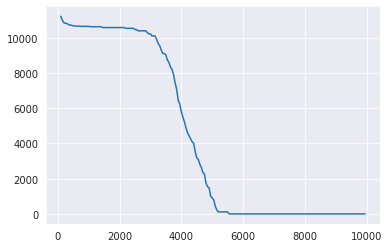

In [9]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_500/copies=3/clusters_unwrapped', 'steps_500')]
paths_wrapped = [(f'{path}/steps_500/copies=3/clusters_wrapped', 'steps_500')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

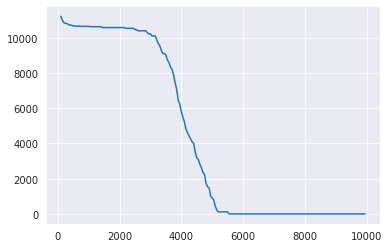

In [11]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_500/copies=3/tol=1e-13/clusters_unwrapped', 'tol=1e-13')]
paths_wrapped = [(f'{path}/steps_500/copies=3/tol=1e-13/clusters_wrapped', 'tol=1e-13')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500_tol=1e-13'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

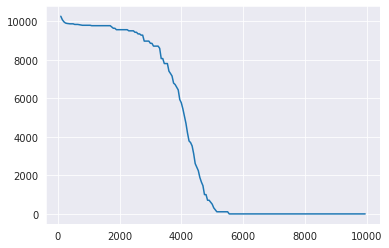

In [16]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_1000/copies=3/clusters_unwrapped', 'steps_1000')]
paths_wrapped = [(f'{path}/steps_1000/copies=3/clusters_wrapped', 'steps_1000')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_1000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

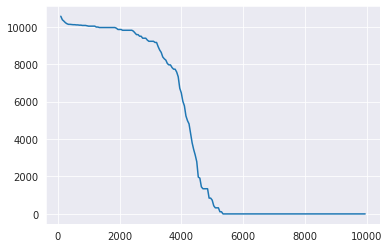

In [17]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_2000/copies=3/clusters_unwrapped', 'steps_2000')]
paths_wrapped = [(f'{path}/steps_2000/copies=3/clusters_wrapped', 'steps_2000')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_2000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

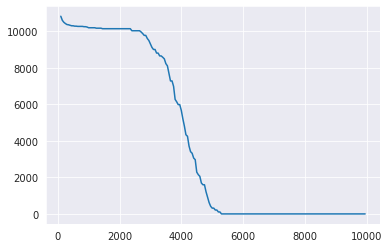

In [18]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_4000/copies=3/clusters_unwrapped', 'steps_4000')]
paths_wrapped = [(f'{path}/steps_4000/copies=3/clusters_wrapped', 'steps_4000')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_4000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

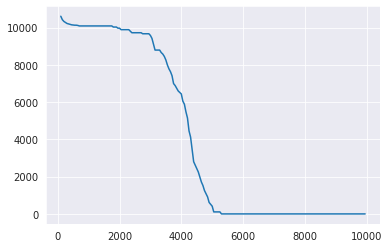

In [15]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_8000/copies=3/clusters_unwrapped', 'steps_8000')]
paths_wrapped = [(f'{path}/steps_8000/copies=3/clusters_wrapped', 'steps_8000')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_8000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

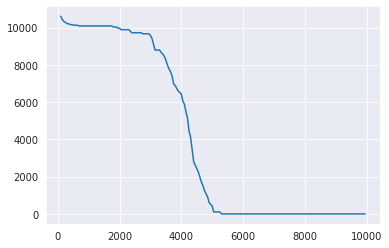

In [12]:
path = '../data/monopoles_su3/gluodynamics/24^4/beta6.0'
paths_unwrapped = [(f'{path}/steps_8000/copies=3/tol=1e-13/clusters_unwrapped', 'tol=1e-13')]
paths_wrapped = [(f'{path}/steps_8000/copies=3/tol=1e-13/clusters_wrapped', 'tol=1e-13')]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_8000_tol=1e-13'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

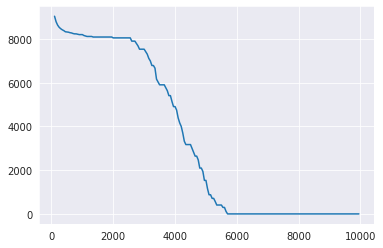

In [21]:
path = '../data/monopoles_su3/gluodynamics/36^4/beta6.3'
paths_unwrapped = [(f'{path}/steps_500/copies=3/clusters_unwrapped', 'steps_500')]
paths_wrapped = [(f'{path}/steps_500/copies=3/clusters_wrapped', 'steps_500')]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

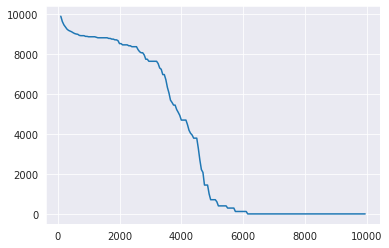

In [22]:
path = '../data/monopoles_su3/gluodynamics/36^4/beta6.3'
paths_unwrapped = [(f'{path}/steps_1000/copies=3/clusters_unwrapped', 'steps_1000')]
paths_wrapped = [(f'{path}/steps_1000/copies=3/clusters_wrapped', 'steps_1000')]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.0'
image_name = 'percolating_cluster_steps_1000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

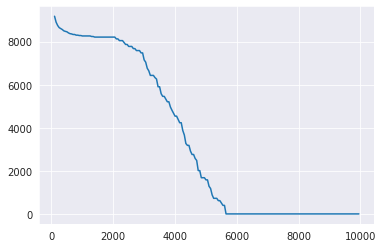

In [23]:
path = '../data/monopoles_su3/gluodynamics/36^4/beta6.3'
paths_unwrapped = [(f'{path}/steps_2000/copies=3/clusters_unwrapped', 'steps_2000')]
paths_wrapped = [(f'{path}/steps_2000/copies=3/clusters_wrapped', 'steps_2000')]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.0'
image_name = 'percolating_cluster_steps_2000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

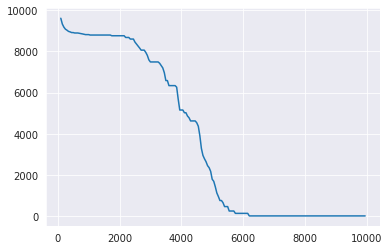

In [24]:
path = '../data/monopoles_su3/gluodynamics/36^4/beta6.3'
paths_unwrapped = [(f'{path}/steps_4000/copies=3/clusters_unwrapped', 'steps_4000')]
paths_wrapped = [(f'{path}/steps_4000/copies=3/clusters_wrapped', 'steps_4000')]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.0'
image_name = 'percolating_cluster_steps_4000'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

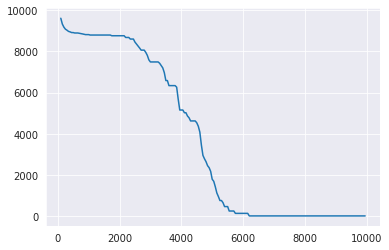

In [13]:
path = '../data/monopoles_su3/gluodynamics/36^4/beta6.3'
paths_unwrapped = [(f'{path}/steps_4000/copies=3/tol=1e-13/clusters_unwrapped', 'tol=1e-13')]
paths_wrapped = [(f'{path}/steps_4000/copies=3/tol=1e-13/clusters_wrapped', 'tol=1e-13')]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.0'
image_name = 'percolating_cluster_steps_4000_tol=1e-13'

percolating_clusters(1, 50, paths_unwrapped, paths_wrapped, 'mag', 100, 10000, 50, image_path, image_name)

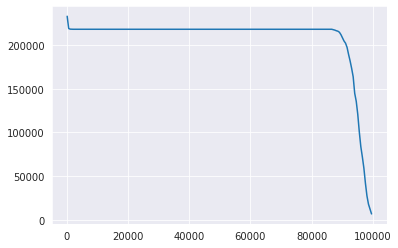

In [44]:
path = '../data/monopoles_su3/QCD/140MeV/nt14'
paths_unwrapped = [(f'{path}/steps_2000/copies=1/clusters_unwrapped', 'tol=1e-05')]
paths_wrapped = [(f'{path}/steps_2000/copies=1/clusters_wrapped', 'tol=1e-05')]
image_path = '../images/monopoles_su3/QCD/140MeV/nt14'
image_name = 'percolating_cluster_steps_2000'

percolating_clusters(501, 1200, paths_unwrapped, paths_wrapped, 'mag', 100, 100000, 500, image_path, image_name)

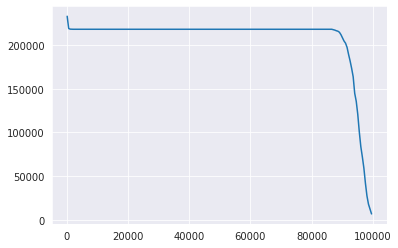

In [45]:
path = '../data/monopoles_su3/QCD/140MeV/nt14'
paths_unwrapped = [(f'{path}/steps_2000/copies=1/clusters_unwrapped', 'tol=1e-13')]
paths_wrapped = [(f'{path}/steps_2000/copies=1/clusters_wrapped', 'tol=1e-13')]
image_path = '../images/monopoles_su3/QCD/140MeV/nt14'
image_name = 'percolating_cluster_steps_2000'

percolating_clusters(501, 1200, paths_unwrapped, paths_wrapped, 'mag', 100, 100000, 500, image_path, image_name)

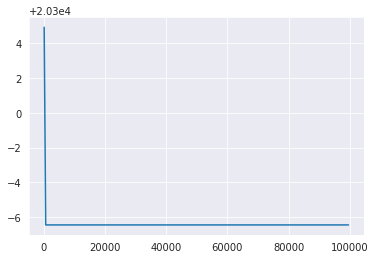

In [46]:
path = '../data/monopoles_su3/QCD/140MeV/nt4'
paths_unwrapped = [(f'{path}/steps_2000/copies=1/clusters_unwrapped', 'tol=1e-05')]
paths_wrapped = [(f'{path}/steps_2000/copies=1/clusters_wrapped', 'tol=1e-05')]
image_path = '../images/monopoles_su3/QCD/140MeV/nt4'
image_name = 'percolating_cluster_steps_2000'

percolating_clusters(501, 1200, paths_unwrapped, paths_wrapped, 'mag', 100, 100000, 500, image_path, image_name)

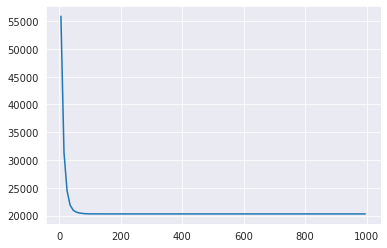

In [52]:
path = '../data/monopoles_su3/QCD/140MeV/nt4'
paths_unwrapped = [(f'{path}/steps_2000/copies=1/clusters_unwrapped', 'tol=1e-13')]
paths_wrapped = [(f'{path}/steps_2000/copies=1/clusters_wrapped', 'tol=1e-13')]
image_path = '../images/monopoles_su3/QCD/140MeV/nt4'
image_name = 'percolating_cluster_steps_2000'

percolating_clusters(501, 1200, paths_unwrapped, paths_wrapped, 'mag', 6, 1000, 10, image_path, image_name)